## Capstone Project: Using Facial Recognition to Identify Celebrities

This notebook contains my capstone project in the Professional Certificate in Machine Learning and Artificial Intelligence cource from the University of California, Berkeley.  The goal of the project is to properly identify a person from their image using ML techniques.

### Motivation

Facial recognition is important for several reasons.  These include enhancing security, streamlining access controls, and relieving or enhancing the capabilities of physical identification for security personnel. 

In [1]:
##Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub
import os
import cv2
from PIL import Image, ImageOps
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Import TensorFlow components
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
import tensorflow as tf

from tensorflow.keras.applications import ResNet50V2




from collections import defaultdict
import pickle
import face_recognition

from sklearn.neighbors import KNeighborsClassifier



/mnt/c/Users/stepa/projects/Capstone/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-29 15:41:08.726590: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 15:41:10.063157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753828869.616009 1015250 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753828869.742054 1015250 cuda_b

### Data Set
The data set below has 17 celebrities with 100 pictures of each.  We will try to properly identify the clebrity based on their images  

In [2]:
# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

#print("Path to dataset files:", path)

Total images: 1800
Mean pixels: 231,733
Median pixels: 231,549
Target pixels (224×224): 50,176
Min pixels: 21,600
Max pixels: 280,608


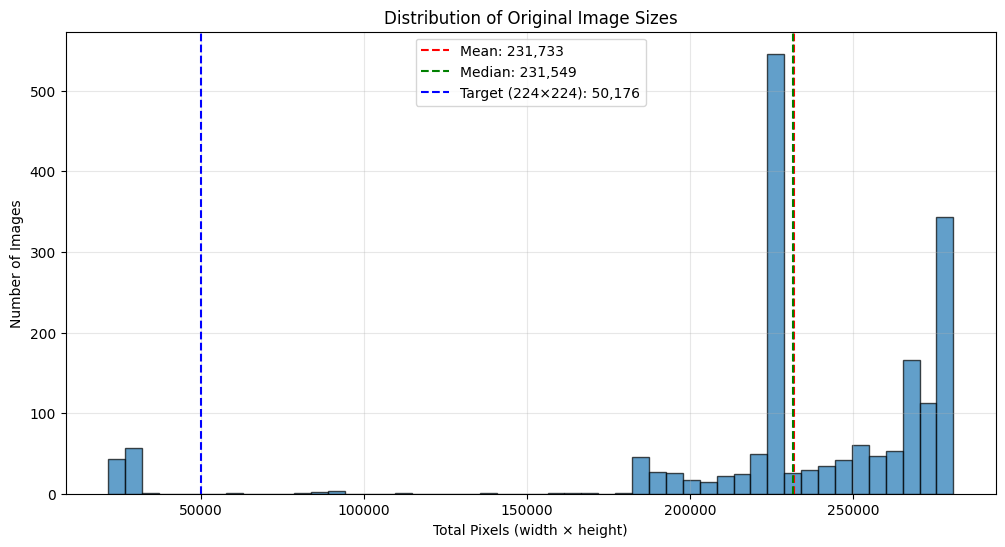

In [3]:
# Collect original image sizes for histogram
base_dir = os.path.expanduser(path + '//Celebrity Faces Dataset')
original_sizes = []

# Traverse each subfolder (person) to get original sizes
for person in os.listdir(base_dir):
    person_dir = os.path.join(base_dir, person)
    if os.path.isdir(person_dir):
        for filename in os.listdir(person_dir):
            if filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
                img_path = os.path.join(person_dir, filename)
                try:
                    img = Image.open(img_path)
                    # Calculate total pixels (width * height)
                    total_pixels = img.size[0] * img.size[1]
                    original_sizes.append(total_pixels)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(original_sizes, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Total Pixels (width × height)')
plt.ylabel('Number of Images')
plt.title('Distribution of Original Image Sizes')
plt.grid(True, alpha=0.3)

# Add some statistics
mean_pixels = np.mean(original_sizes)
median_pixels = np.median(original_sizes)
target_pixels = 224 * 224  # Our target size

plt.axvline(mean_pixels, color='red', linestyle='--', label=f'Mean: {mean_pixels:,.0f}')
plt.axvline(median_pixels, color='green', linestyle='--', label=f'Median: {median_pixels:,.0f}')
plt.axvline(target_pixels, color='blue', linestyle='--', label=f'Target (224×224): {target_pixels:,}')

plt.legend()

print(f"Total images: {len(original_sizes)}")
print(f"Mean pixels: {mean_pixels:,.0f}")
print(f"Median pixels: {median_pixels:,.0f}")
print(f"Target pixels (224×224): {target_pixels:,}")
print(f"Min pixels: {min(original_sizes):,}")
print(f"Max pixels: {max(original_sizes):,}")

plt.show()

### Reading in the Images to be classifed
- Using the Python Image Library (PIL) we can achieve the following:
   - Convert all images to the same size with each having 3 channels of data
   - Greyscale images have their channels duplicated
   - Aspect ratios are corrected through cropping
   - Image size is correct through blurring or upsampling
- After reading in the images equalize the data set by dropping any oversampled celebrities

In [4]:
# Path to the dataset
base_dir = os.path.expanduser(path + '//Celebrity Faces Dataset')
image_size = (224, 224)  # You can change this if you want a different size
print(base_dir)
images = []
labels = []
small_images = []  # List to track images smaller than 224x224

# Traverse each subfolder (person)
for person in os.listdir(base_dir):
    person_dir = os.path.join(base_dir, person)
    if os.path.isdir(person_dir):
        for filename in os.listdir(person_dir):
            if filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
                img_path = os.path.join(person_dir, filename)
                try:
                    img = Image.open(img_path).convert('RGB')                  

                    # Check if image is smaller than 224x224
                    original_pixels = img.size[0] * img.size[1]
                    target_pixels = 224 * 224
                    
                    if original_pixels < target_pixels:
                        small_images.append({
                            'person': person,
                            'filename': filename,
                            'original_size': img.size,
                            'original_pixels': original_pixels
                        })
                    
                    img = ImageOps.pad(img, image_size, color=(0, 0, 0))
                    #img = img.convert('L')
                    images.append(np.array(img))
                    labels.append(person)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")

images_np = np.array(images)
labels_np = np.array(labels)

#print(images_np.shape)  # (num_images, 224, 224, 3)
#print(labels_np.shape)  # (num_images,)
print(f"Number of images smaller than 224x224: {len(small_images)}")


/home/jack/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1//Celebrity Faces Dataset
Number of images smaller than 224x224: 101


In [5]:
# Step 1: Find the minimum number of images per celebrity
# Set the random seed for reproducible results
random.seed(42)  

images_per_celebrity = {}
for img, label in zip(images, labels):
    if label not in images_per_celebrity:
        images_per_celebrity[label] = []
    images_per_celebrity[label].append(img)

min_images = min(len(imgs) for imgs in images_per_celebrity.values())
print("Minimum images per celebrity:", min_images)

# Step 2: For each celebrity, randomly sample min_images images
balanced_images_per_celebrity = {}
for celeb, imgs in images_per_celebrity.items():
    if len(imgs) > min_images:
        balanced_images_per_celebrity[celeb] = random.sample(imgs, min_images)
    else:
        balanced_images_per_celebrity[celeb] = imgs

# Step 3: Create balanced images and labels lists
balanced_images = []
balanced_labels = []
for celeb, imgs in balanced_images_per_celebrity.items():
    balanced_images.extend(imgs)
    balanced_labels.extend([celeb] * len(imgs))

print("Original dataset size:", len(images))
print("Balanced dataset size:", len(balanced_images))
print("Images per celebrity:", min_images)

Minimum images per celebrity: 100
Original dataset size: 1800
Balanced dataset size: 1700
Images per celebrity: 100


#### Plot all the images to ensure they are as expected and we don't have any blanks or weird outliers

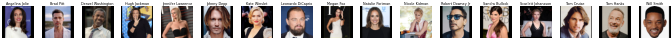

In [6]:
# Get all unique celebrities from the balanced dataset
unique_celebrities = sorted(set(balanced_labels))
num_cols = len(unique_celebrities)

# Collect all images for each celebrity from the balanced dataset
images_per_celebrity = {celeb: [] for celeb in unique_celebrities}
for img, label in zip(balanced_images, balanced_labels):  # Use balanced_images and balanced_labels
    images_per_celebrity[label].append(img)

# Find the maximum number of images any celebrity has 
max_images = max(len(imgs) for imgs in images_per_celebrity.values())
max_images = 1
# Plot grid: rows = max_images, columns = num_cols (one per celebrity)
plt.figure(figsize=(2*num_cols, 2*max_images),  dpi=20)
for col, celeb in enumerate(unique_celebrities):
    for row in range(max_images):
        idx = row * num_cols + col + 1
        plt.subplot(max_images, num_cols, idx)
        if row < len(images_per_celebrity[celeb]):
            plt.imshow(images_per_celebrity[celeb][row])
        plt.axis('off')
        if row == 0:
            plt.title(celeb, fontsize=12)
plt.tight_layout()
plt.show()



#### Data Reduction Summary and Next Steps
- Pruning the data set into something usable was fairly straightforward the numpy libraries do a good job of sizing and handling images for training
- We will try Four techniques to classify the images:
    - Importing Google's facenet library
    - Using our own crafted Convolutional Neural Network (CNN)
    - Using a transfer learing Neural Network 
    - Using a K Nearest Neighbors (KNN) approach to identify the celebrities 


In [7]:
def extract_face_encodings(images, labels):
    """Extract face encodings from images"""
    #print("Extracting face encodings...")
    
    face_encodings = []
    valid_labels = []
    failed_images = []
    
    for i, (img, label) in enumerate(zip(images, labels)):
        #if i % 100 == 0:
            #print(f"Processing image {i}/{len(images)}")
        
        try:
            # Convert to RGB if needed
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            
            # Detect faces and extract encodings
            encodings = face_recognition.face_encodings(img)
            
            if len(encodings) > 0:
                # Use the first face found
                face_encodings.append(encodings[0])
                valid_labels.append(label)
            else:
                failed_images.append(i)
                #print(f"No face detected in image {i}")
                
        except Exception as e:
            failed_images.append(i)
            print(f"Error processing image {i}: {e}")
    
    print(f"Successfully processed {len(face_encodings)} images")
    print(f"Failed to process {len(failed_images)} images")
    
    return np.array(face_encodings), np.array(valid_labels), failed_images

# Extract face encodings first
#print("=== EXTRACTING FACE ENCODINGS ===")
face_encodings, valid_labels, failed_images = extract_face_encodings(
    balanced_images, balanced_labels
)

# Do the train/test split 
#print("=== CREATING TRAIN/TEST SPLIT ===")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(valid_labels)
celebrity_names = le.classes_

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    face_encodings, y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Successfully processed 1669 images
Failed to process 31 images
Training samples: 1168
Test samples: 501


In [8]:
### Helper Functions

def face_recognition_train_test(X_train, X_test, y_train, y_test, celebrity_names, tolerance=0.6):
    """Face recognition using pre-split data"""
    
    #print(f"Training samples: {len(X_train)}")
    #print(f"Test samples: {len(X_test)}")
    #print(f"Number of celebrities: {len(celebrity_names)}")
    
    # Test face recognition
    correct_predictions = 0
    total_predictions = len(X_test)
    predictions = []
    true_labels = []
    
    #print(f"Testing with tolerance: {tolerance}")
    
    for i, test_encoding in enumerate(X_test):
        #if i % 50 == 0:
        #    print(f"Processing test image {i}/{len(X_test)}")
        
        # Get face distances to all training faces
        face_distances = face_recognition.face_distance(X_train, test_encoding)
        
        # Find the closest match
        best_match_index = np.argmin(face_distances)
        best_distance = face_distances[best_match_index]
        
        # Get true and predicted labels
        true_label = y_test[i]
        predicted_label = y_train[best_match_index]
        
        # Check if prediction is correct (within tolerance)
        if best_distance <= tolerance:
            if predicted_label == true_label:
                correct_predictions += 1
            predictions.append(predicted_label)
        else:
            predictions.append(predicted_label)
        
        true_labels.append(true_label)
    
    # Calculate overall accuracy
    overall_accuracy = correct_predictions / total_predictions
    
    #print(f"Correct predictions: {correct_predictions}/{total_predictions}")
    #print(f"Overall accuracy: {overall_accuracy:.4f}")
    
    return overall_accuracy, predictions, true_labels

def analyze_celebrity_performance_train_test(predictions, true_labels, celebrity_names, X_train, X_test, y_train, y_test, tolerance=0.6):
    """Analyze performance per celebrity using train/test split"""
    
    # Dictionary to store results for each celebrity
    celebrity_results = {name: {'correct': 0, 'total': 0, 'distances': []} for name in celebrity_names}
    
    for i, (pred, true) in enumerate(zip(predictions, true_labels)):
        celeb_name = celebrity_names[true]
        
        # Get the actual distance for this prediction
        test_encoding = X_test[i]
        face_distances = face_recognition.face_distance(X_train, test_encoding)
        best_distance = np.min(face_distances)
        
        celebrity_results[celeb_name]['total'] += 1
        celebrity_results[celeb_name]['distances'].append(best_distance)
        
        if pred == true:
            celebrity_results[celeb_name]['correct'] += 1
    
    # Calculate statistics per celebrity
    celebrity_accuracies = {}
    for celeb in celebrity_names:
        if celebrity_results[celeb]['total'] > 0:
            accuracy = celebrity_results[celeb]['correct'] / celebrity_results[celeb]['total']
            mean_distance = np.mean(celebrity_results[celeb]['distances'])
            std_distance = np.std(celebrity_results[celeb]['distances'])
            
            celebrity_accuracies[celeb] = {
                'accuracy': accuracy,
                'mean_distance': mean_distance,
                'std_distance': std_distance,
                'total_samples': celebrity_results[celeb]['total'],
                'correct_predictions': celebrity_results[celeb]['correct']
            }
    
    return celebrity_accuracies

def visualize_train_test_results(celebrity_accuracies, overall_accuracy):
    """Visualize train/test results"""
    celebrities = list(celebrity_accuracies.keys())
    accuracies = [celebrity_accuracies[celeb]['accuracy'] for celeb in celebrities]
    mean_distances = [celebrity_accuracies[celeb]['mean_distance'] for celeb in celebrities]
    sample_counts = [celebrity_accuracies[celeb]['total_samples'] for celeb in celebrities]
    
    # Sort by accuracy
    sorted_indices = np.argsort(accuracies)
    celebrities_sorted = [celebrities[i] for i in sorted_indices]
    accuracies_sorted = [accuracies[i] for i in sorted_indices]
    mean_distances_sorted = [mean_distances[i] for i in sorted_indices]
    sample_counts_sorted = [sample_counts[i] for i in sorted_indices]
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Accuracy per celebrity
    plt.subplot(2, 2, 1)
    bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
    plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
    plt.xlabel('Accuracy')
    plt.title(f'Face Recognition Accuracy per Celebrity\n(Overall: {overall_accuracy:.3f})')
    plt.xlim(0, 1)
    
    # Color bars based on performance
    for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
        if acc >= 0.8:
            bar.set_color('green')
        elif acc >= 0.6:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    # Plot 2: Mean face distance per celebrity
    plt.subplot(2, 2, 2)
    plt.barh(range(len(celebrities_sorted)), mean_distances_sorted)
    plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
    plt.xlabel('Mean Face Distance')
    plt.title('Mean Face Distance per Celebrity\n(Lower = Better)')
    
    # Plot 3: Accuracy vs Mean Distance
    plt.subplot(2, 2, 3)
    plt.scatter(mean_distances_sorted, accuracies_sorted, s=100, alpha=0.7)
    for i, celeb in enumerate(celebrities_sorted):
        plt.annotate(celeb, (mean_distances_sorted[i], accuracies_sorted[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8, rotation=45)
    plt.xlabel('Mean Face Distance')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Mean Face Distance')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.9, 1.1)
    
    # Plot 4: Sample distribution
    plt.subplot(2, 2, 4)
    plt.pie(sample_counts_sorted, labels=celebrities_sorted, autopct='%1.1f%%')
    plt.title('Test Sample Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    #print(f"\n{'='*50}")
    #print("DETAILED RESULTS PER CELEBRITY")
    #print(f"{'='*50}")
    
    # Sort by accuracy (best first)
    sorted_by_acc = sorted(celebrity_accuracies.items(), 
                          key=lambda x: x[1]['accuracy'], reverse=True)
    
    for i, (celeb, results) in enumerate(sorted_by_acc):
        print(f"{i+1:2d}. {celeb:20s}: {results['accuracy']:.3f} "
              f"(distance: {results['mean_distance']:.3f}±{results['std_distance']:.3f}) "
              f"[{results['correct_predictions']}/{results['total_samples']} samples]")
    
    # Summary statistics
    all_accuracies = [results['accuracy'] for results in celebrity_accuracies.values()]
    all_distances = [results['mean_distance'] for results in celebrity_accuracies.values()]
    
    print(f"\nSummary:")
    print(f"  Overall accuracy: {overall_accuracy:.3f}")
    print(f"  Mean accuracy across celebrities: {np.mean(all_accuracies):.3f}")
    print(f"  Std accuracy across celebrities: {np.std(all_accuracies):.3f}")
    print(f"  Mean face distance: {np.mean(all_distances):.3f}")
    print(f"  Best celebrity: {sorted_by_acc[0][0]} ({sorted_by_acc[0][1]['accuracy']:.3f})")
    print(f"  Worst celebrity: {sorted_by_acc[-1][0]} ({sorted_by_acc[-1][1]['accuracy']:.3f})")



1. Running face recognition...
2. Analyzing celebrity performance...


3. Visualizing results...


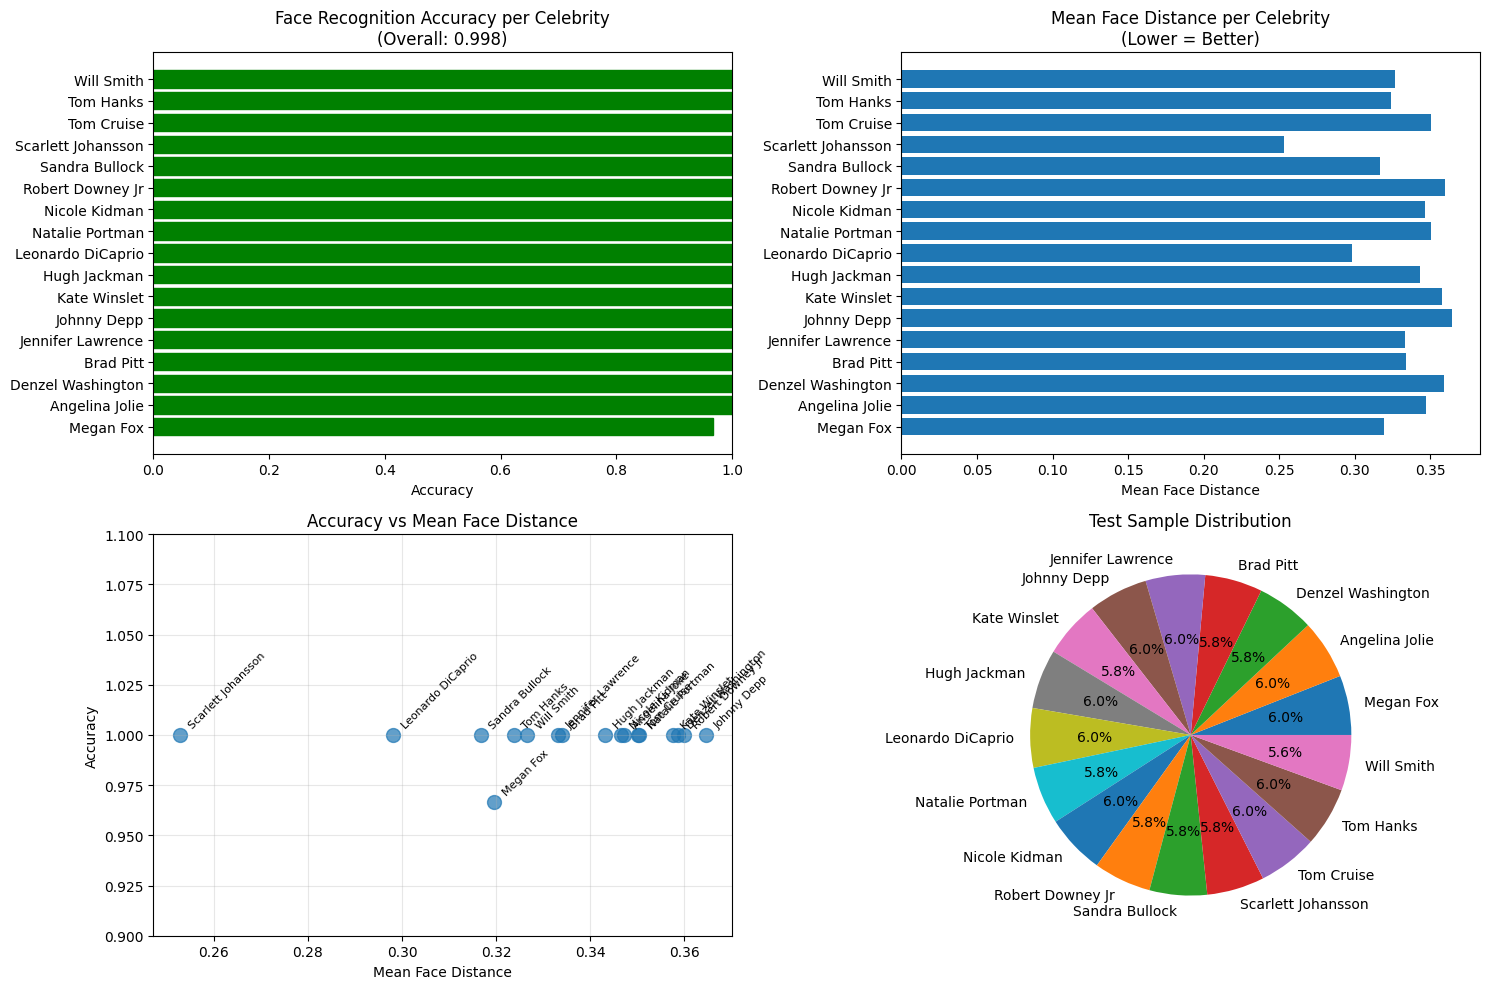

 1. Angelina Jolie      : 1.000 (distance: 0.347±0.087) [30/30 samples]
 2. Brad Pitt           : 1.000 (distance: 0.334±0.070) [29/29 samples]
 3. Denzel Washington   : 1.000 (distance: 0.359±0.067) [29/29 samples]
 4. Hugh Jackman        : 1.000 (distance: 0.343±0.059) [30/30 samples]
 5. Jennifer Lawrence   : 1.000 (distance: 0.333±0.051) [30/30 samples]
 6. Johnny Depp         : 1.000 (distance: 0.365±0.059) [30/30 samples]
 7. Kate Winslet        : 1.000 (distance: 0.358±0.089) [29/29 samples]
 8. Leonardo DiCaprio   : 1.000 (distance: 0.298±0.082) [30/30 samples]
 9. Natalie Portman     : 1.000 (distance: 0.350±0.056) [29/29 samples]
10. Nicole Kidman       : 1.000 (distance: 0.347±0.057) [30/30 samples]
11. Robert Downey Jr    : 1.000 (distance: 0.360±0.069) [29/29 samples]
12. Sandra Bullock      : 1.000 (distance: 0.317±0.060) [29/29 samples]
13. Scarlett Johansson  : 1.000 (distance: 0.253±0.150) [29/29 samples]
14. Tom Cruise          : 1.000 (distance: 0.350±0.089) [30/30 s

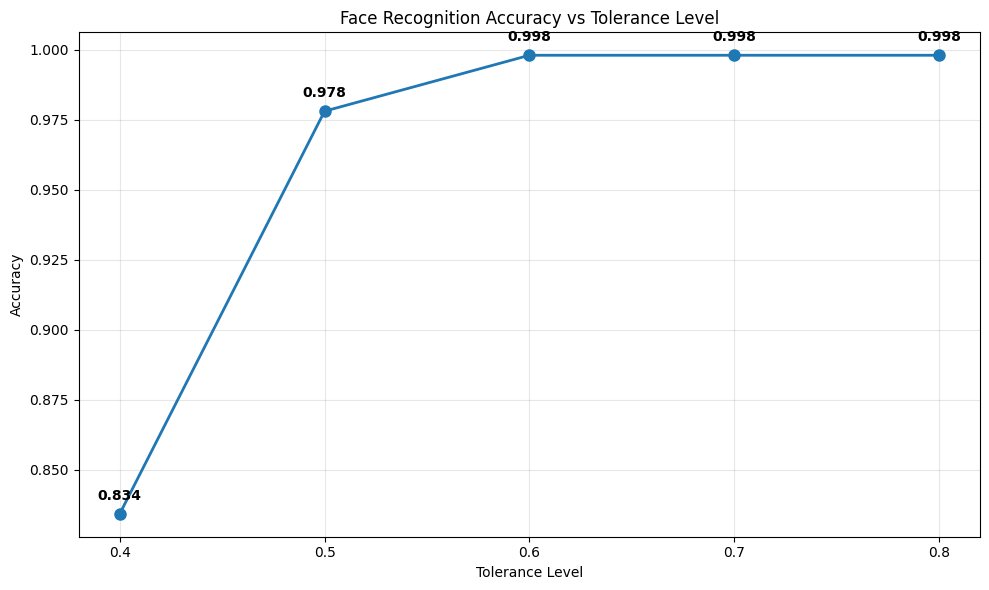


Best tolerance: 0.6
Best accuracy: 0.998


In [9]:
# Main execution
#print("=== FACE RECOGNITION ANALYSIS ===")

print("1. Running face recognition...")
overall_accuracy, predictions, true_labels = face_recognition_train_test(
    X_train, X_test, y_train, y_test, celebrity_names, tolerance=0.6
)

print("2. Analyzing celebrity performance...")
celebrity_accuracies = analyze_celebrity_performance_train_test(
    predictions, true_labels, celebrity_names, X_train, X_test, y_train, y_test, tolerance=0.6
)

print("3. Visualizing results...")
visualize_train_test_results(celebrity_accuracies, overall_accuracy)
# Test different tolerance levels

print("4. Testing different tolerance levels...")
tolerance_levels = [0.4, 0.5, 0.6, 0.7, 0.8]
tolerance_results = {}

for tolerance in tolerance_levels:
    #print(f"\nTesting tolerance: {tolerance}")
    acc, _, _ = face_recognition_train_test(
        X_train, X_test, y_train, y_test, celebrity_names, tolerance=tolerance
    )
    tolerance_results[tolerance] = acc

# Plot tolerance results
plt.figure(figsize=(10, 6))
tolerances = list(tolerance_results.keys())
accuracies = list(tolerance_results.values())

plt.plot(tolerances, accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('Tolerance Level')
plt.ylabel('Accuracy')
plt.title('Face Recognition Accuracy vs Tolerance Level')
plt.grid(True, alpha=0.3)
plt.xticks(tolerances)

# Add value labels on points
for i, (tol, acc) in enumerate(zip(tolerances, accuracies)):
    plt.annotate(f'{acc:.3f}', (tol, acc), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nBest tolerance: {max(tolerance_results, key=tolerance_results.get)}")
print(f"Best accuracy: {max(tolerance_results.values()):.3f}")

## Facenet Results

This serves as a good baseline for can be achieved using a semantic model. It performs very well on the data set.  Intially, I tried to train a CNN on the data set and achieved very poor results. What became apparent as I used the facenet model is that the face face extraction is key to achieving results.  We'll use the facenets face extraction feature to train our other models.  However, openCV, and Dlib also provide face extraction capabilities.  These alternatives were not explored because the goal was to use identify the faces from the data and not compare face extraction models.

In [10]:

def detect_and_crop_faces(images, labels):
    """Just detect and crop faces without encoding"""
    print("Detecting and cropping faces...")
    
    cropped_faces = []
    valid_labels = []
    failed_images = []
    face_locations = []
    
    for i, (img, label) in enumerate(zip(images, labels)):
        #if i % 100 == 0:
        #    print(f"Processing image {i}/{len(images)}")
        
        try:
            # Convert to RGB if needed
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            
            # Detect face locations
            locations = face_recognition.face_locations(img)
            
            if len(locations) > 0:
                # Use the first face found
                top, right, bottom, left = locations[0]
                
                # Crop the face with some margin
                margin = 20
                top = max(0, top - margin)
                left = max(0, left - margin)
                bottom = min(img.shape[0], bottom + margin)
                right = min(img.shape[1], right + margin)
                
                # Crop the face
                face_crop = img[top:bottom, left:right]
                
                # Resize to standard size
                face_crop = cv2.resize(face_crop, (224, 224))
                
                cropped_faces.append(face_crop)
                valid_labels.append(label)
                face_locations.append(locations[0])
            else:
                failed_images.append(i)
                #print(f"No face detected in image {i}")
                
        except Exception as e:
            failed_images.append(i)
            print(f"Error processing image {i}: {e}")
    
    print(f"Successfully cropped {len(cropped_faces)} faces")
    print(f"Failed to process {len(failed_images)} images")
    
    return np.array(cropped_faces), np.array(valid_labels), failed_images, face_locations



# Use face_recognition for detection and cropping
#print("=== Face Detection with face_recognition ===")
cropped_faces, valid_labels, failed_images, face_locations = detect_and_crop_faces(
    balanced_images, balanced_labels
)



Detecting and cropping faces...
Successfully cropped 1669 faces
Failed to process 31 images


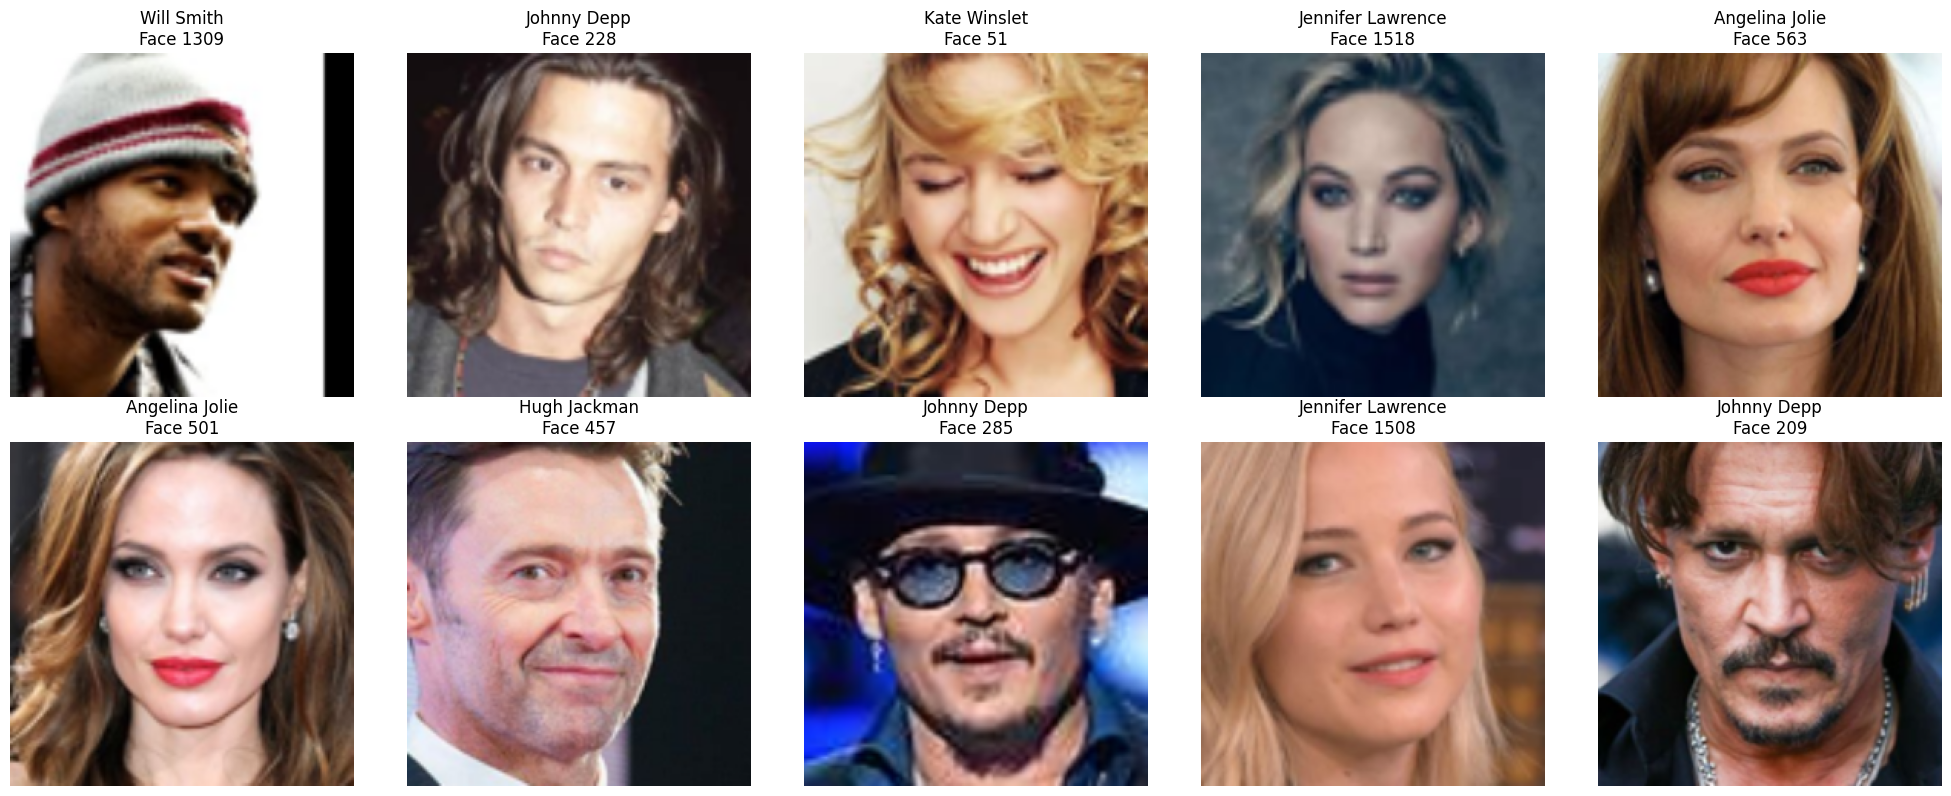

In [11]:
# Visualize some cropped faces
def visualize_cropped_faces(cropped_faces, labels, num_samples=10):
    """Visualize some cropped faces"""
    import random
    
    # Randomly sample faces
    random.seed(42)
    indices = random.sample(range(len(cropped_faces)), min(num_samples, len(cropped_faces)))
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i < len(axes):
            axes[i].imshow(cropped_faces[idx])
            axes[i].set_title(f'{labels[idx]}\nFace {idx}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize the cropped faces
visualize_cropped_faces(cropped_faces, valid_labels, num_samples=10)

## Split and Resize Data

In [12]:
# Resize images to smaller dimensions
def resize_images(images, target_size=(32, 32)):
    """Resize all images to smaller dimensions"""
    resized_images = []
    for img in images:
        # Convert numpy array to PIL Image
        pil_img = Image.fromarray(img.astype('uint8'))
        # Resize
        resized_img = pil_img.resize(target_size, Image.Resampling.LANCZOS)
        # Convert back to numpy array
        resized_images.append(np.array(resized_img))
    return np.array(resized_images)

# Resize your images to 64x64 (much smaller)
target_size = (128, 128)
resized_images = resize_images(cropped_faces, target_size)

print(f"Original shape: {np.array(cropped_faces).shape}")
print(f"Resized shape: {resized_images.shape}")

# Normalize
images_normalized = resized_images.astype('float32') / 255.0

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(valid_labels)

num_classes = len(le.classes_)
print(f"Number of celebrities: {num_classes}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    images_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)



Original shape: (1669, 224, 224, 3)
Resized shape: (1669, 128, 128, 3)
Number of celebrities: 17


## Custom CNN

/mnt/c/Users/stepa/projects/Capstone/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753829136.188286 1015250 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753,361 (10.50 MB)

 Trainable params: 2,753,361 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1753829140.867139 1018249 service.cc:152] XLA service 0x78b3a0012ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753829140.867253 1018249 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-29 15:45:41.004307: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753829141.591207 1018249 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753829151.963852 1018249 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-29 15:46:00.183373: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116_0', 44 bytes spill stores, 44 bytes spill loads

2025-07-29 15:46:00.71609

Test accuracy: 0.5269


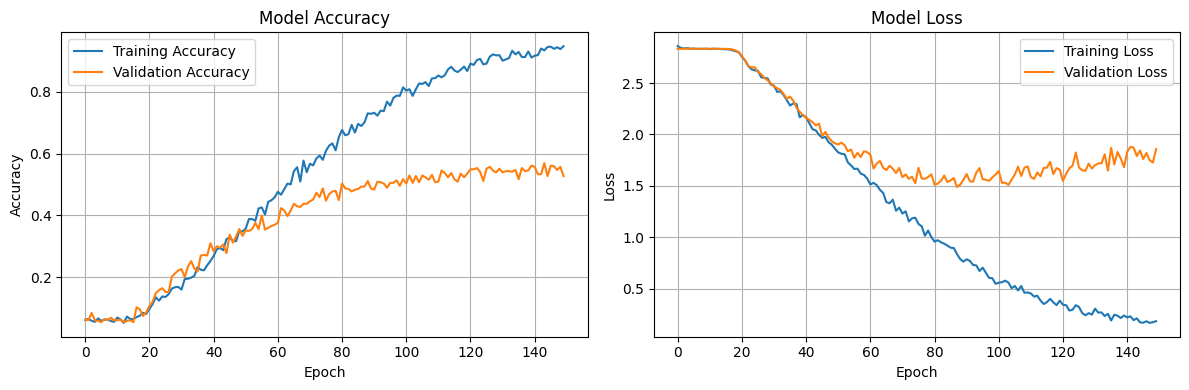

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


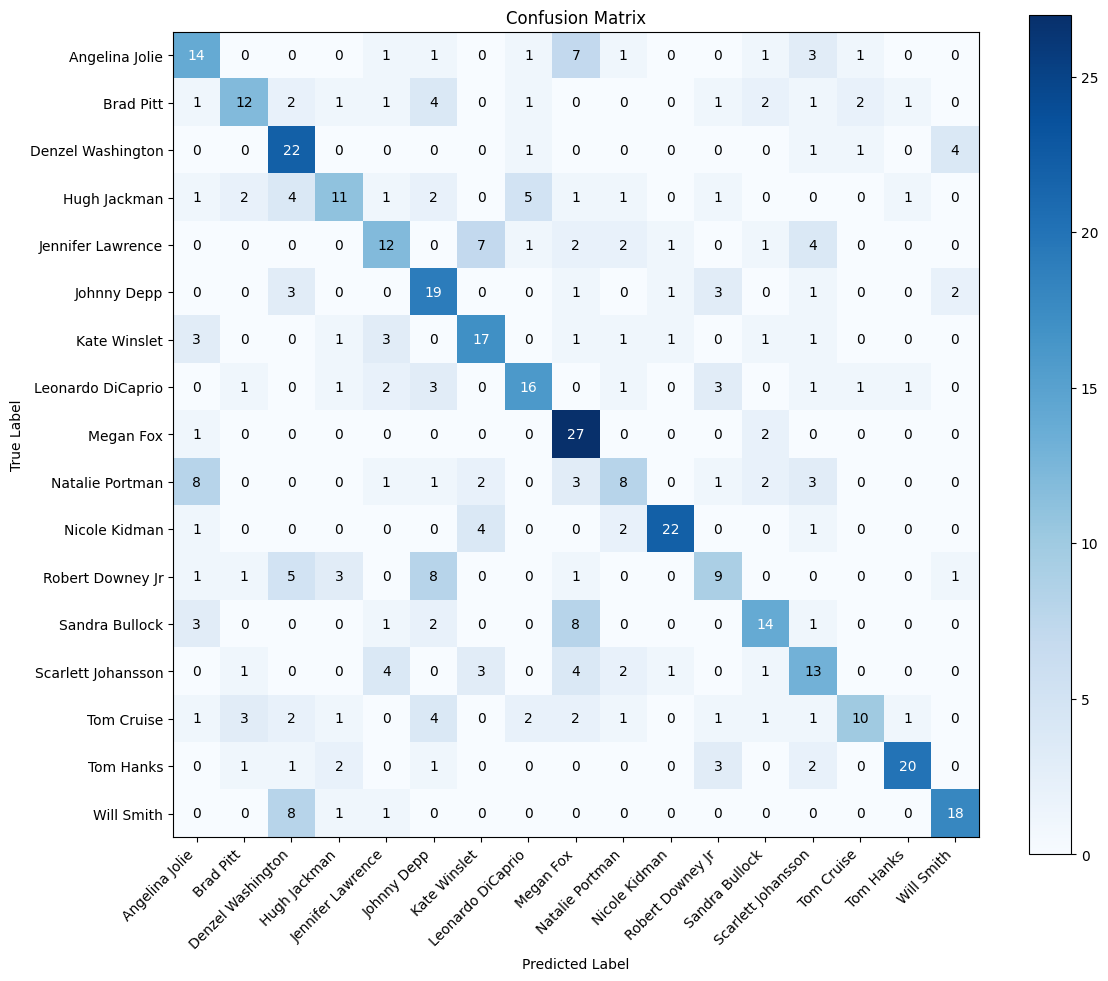

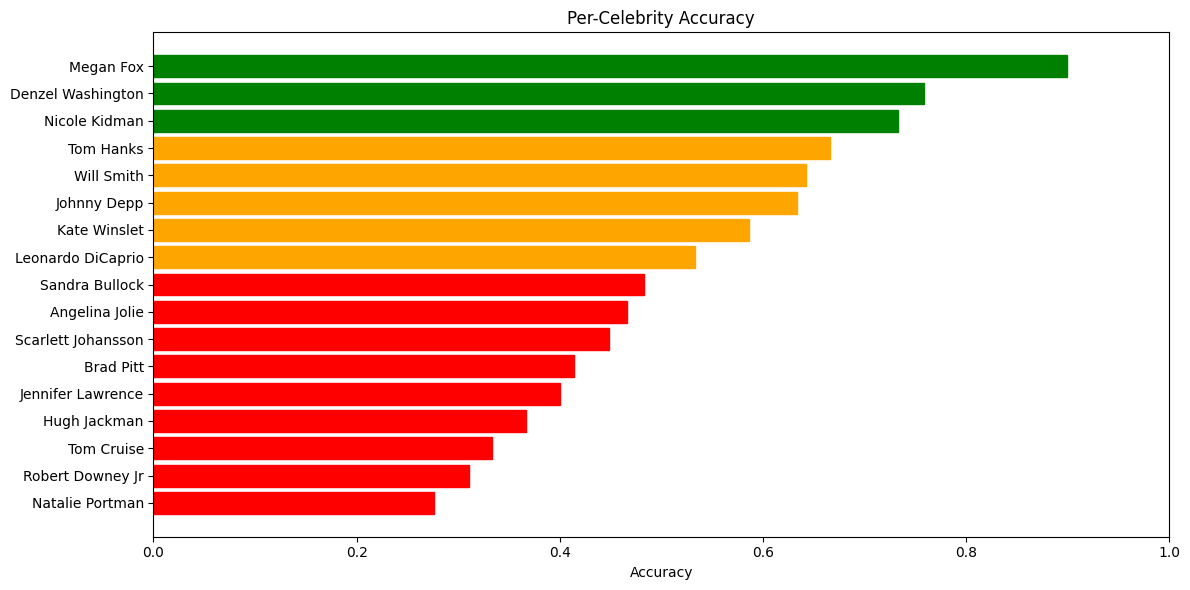

In [13]:
# Create model 

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(512, (3, 3), activation='relu'),  # Extra conv layer
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    #optimizer=Adam(learning_rate=0.0001),
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=32,
    verbose=0
)

# Evaluate
test_loss, test_accuracy_cnn = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy_cnn:.4f}")


# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get predictions for detailed analysis
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45, ha='right')
plt.yticks(range(len(le.classes_)), le.classes_)
plt.tight_layout()
plt.show()

# Per-celebrity accuracy
celeb_accuracies = {}
for i, celeb in enumerate(le.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        celeb_accuracy = np.mean(y_pred_classes[mask] == y_test[mask])
        celeb_accuracies[celeb] = celeb_accuracy
        #print(f"{celeb:20s}: {celeb_accuracy:.3f} ({np.sum(mask)} samples)")

# Plot per-celebrity accuracy as bar chart
plt.figure(figsize=(12, 6))
celebrities = list(celeb_accuracies.keys())
accuracies = list(celeb_accuracies.values())

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
celebrities_sorted = [celebrities[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
plt.xlabel('Accuracy')
plt.title('Per-Celebrity Accuracy')
plt.xlim(0, 1)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    if acc >= 0.7:
        bar.set_color('green')
    elif acc >= 0.5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

## Custom CNN results

Initially I tried this algorithm without the face extraction algorithm and struggled to achieve a deteciton better than 20%.  Once I added the face extraction I was able to achieve about 55% correct classification.  This is because the loss for the validation set plateaus for the validation set while while the accuracy gets better for the training set.  This implies the model is becoiming overtrained.  I tried additional layers, changing learing rates, and adding call backs.  However, none of these achieved better than what is shown here. 

## Imagenet Transfer Learning

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,749,585 (94.41 MB)

 Trainable params: 1,184,785 (4.52 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

2025-07-29 15:48:37.344233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5516', 204 bytes spill stores, 204 bytes spill loads

2025-07-29 15:48:38.101700: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8142', 16 bytes spill stores, 16 bytes spill loads

2025-07-29 15:48:38.327149: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8142', 40 bytes spill stores, 40 bytes spill loads

2025-07-29 15:48:38.474679: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8142', 32 bytes spill stores, 32 bytes spill loads

2025-07-29 15:48:38.598489: I external

Test accuracy: 0.5689


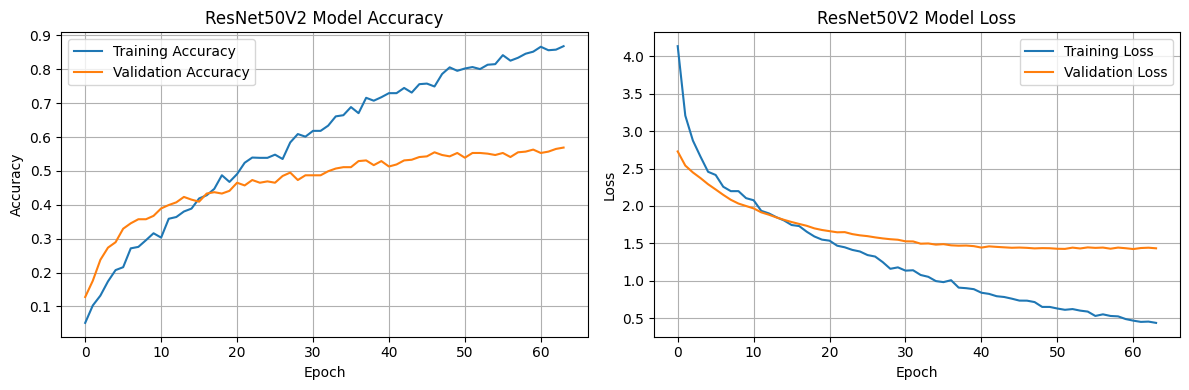

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step


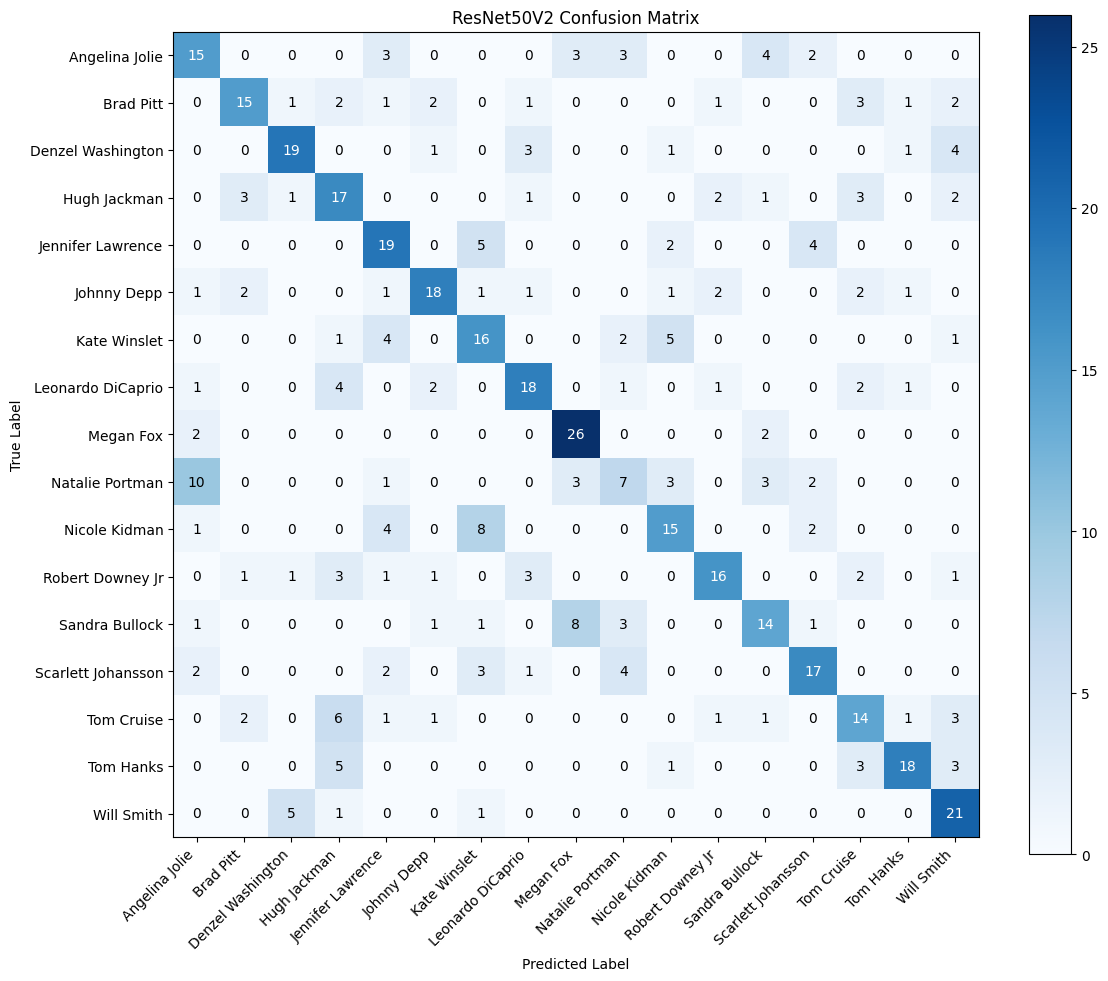

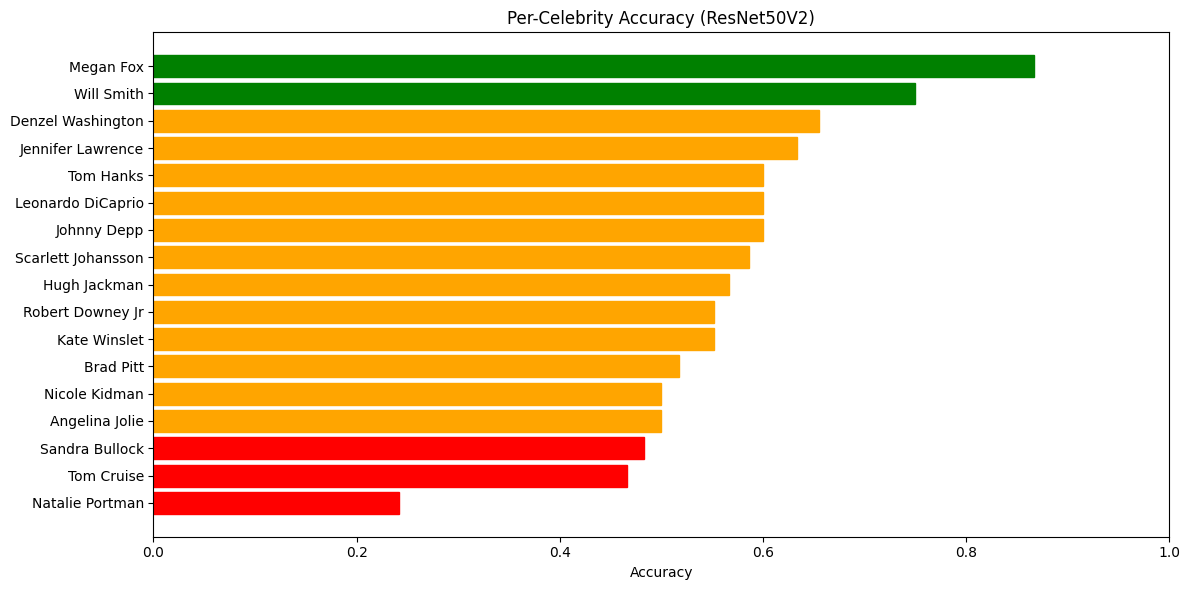

In [14]:
# Use pre-trained ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze pre-trained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=64,  
    batch_size=32,
    verbose=0
)

# Evaluate
test_loss, test_accuracy_tl = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy_tl:.4f}")


#####PLOTS#####

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50V2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50V2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Get predictions for detailed analysis
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('ResNet50V2 Confusion Matrix')
plt.colorbar()

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45, ha='right')
plt.yticks(range(len(le.classes_)), le.classes_)
plt.tight_layout()
plt.show()

# Per-celebrity accuracy bar chart
#print("\n=== Per-Celebrity Accuracy (ResNet50V2) ===")
celeb_accuracies = {}
for i, celeb in enumerate(le.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        celeb_accuracy = np.mean(y_pred_classes[mask] == y_test[mask])
        celeb_accuracies[celeb] = celeb_accuracy
        #print(f"{celeb:20s}: {celeb_accuracy:.3f} ({np.sum(mask)} samples)")

# Plot per-celebrity accuracy as bar chart
plt.figure(figsize=(12, 6))
celebrities = list(celeb_accuracies.keys())
accuracies = list(celeb_accuracies.values())

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
celebrities_sorted = [celebrities[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
plt.xlabel('Accuracy')
plt.title('Per-Celebrity Accuracy (ResNet50V2)')
plt.xlim(0, 1)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    if acc >= 0.7:
        bar.set_color('green')
    elif acc >= 0.5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()


## Imagenet Transfer Learning Results

The results are very similar to the custom CNN where we see the results plateau around 55% accuracy.  Again, because the loss for the validation set plateaus for the validation set, while while the accuracy gets better for the training set.

## KNN

=== KNN Grid Search CV ===
Starting grid search...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth


Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best cross-validation accuracy: 0.2671
Test accuracy with best model: 0.2934


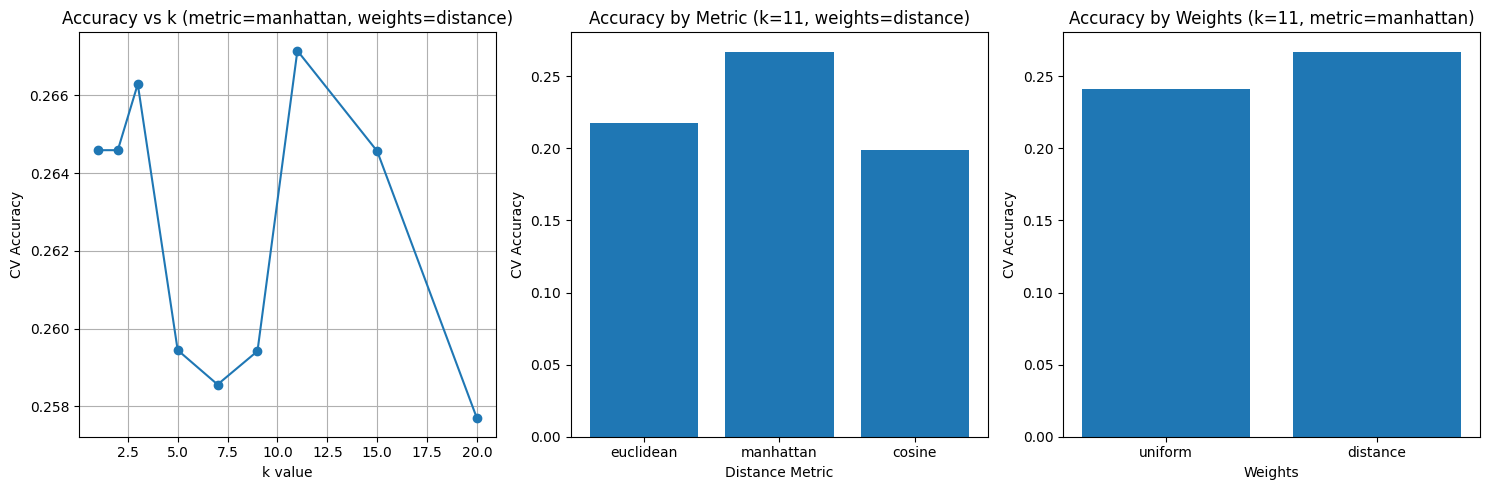

In [17]:

print("=== KNN Grid Search CV ===")

# Define the parameter grid
param_grid = {
    'n_neighbors': [1, 2, 3, 5, 7, 9, 11, 15, 20],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'weights': ['uniform', 'distance']
}

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create KNN classifier
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search...")
grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_flat, y_train)

# Print results
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Test on held-out test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_flat)
test_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Test accuracy with best model: {test_accuracy:.4f}")
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Accuracy by k value (best metric/weights)
plt.subplot(1, 3, 1)
best_params = grid_search.best_params_
best_metric = best_params['metric']
best_weights = best_params['weights']

k_results = results_df[
    (results_df['param_metric'] == best_metric) & 
    (results_df['param_weights'] == best_weights)
].sort_values('param_n_neighbors')

plt.plot(k_results['param_n_neighbors'], k_results['mean_test_score'], marker='o')
plt.xlabel('k value')
plt.ylabel('CV Accuracy')
plt.title(f'Accuracy vs k (metric={best_metric}, weights={best_weights})')
plt.grid(True)

# Plot 2: Accuracy by metric (best k/weights)
plt.subplot(1, 3, 2)
best_k = best_params['n_neighbors']
metric_results = results_df[
    (results_df['param_n_neighbors'] == best_k) & 
    (results_df['param_weights'] == best_weights)
]

plt.bar(metric_results['param_metric'], metric_results['mean_test_score'])
plt.xlabel('Distance Metric')
plt.ylabel('CV Accuracy')
plt.title(f'Accuracy by Metric (k={best_k}, weights={best_weights})')

# Plot 3: Accuracy by weights (best k/metric)
plt.subplot(1, 3, 3)
weights_results = results_df[
    (results_df['param_n_neighbors'] == best_k) & 
    (results_df['param_metric'] == best_metric)
]

plt.bar(weights_results['param_weights'], weights_results['mean_test_score'])
plt.xlabel('Weights')
plt.ylabel('CV Accuracy')
plt.title(f'Accuracy by Weights (k={best_k}, metric={best_metric})')

plt.tight_layout()
plt.show()


(1168, 49152)
(501, 49152)
Training KNN with 49152 features per image

Training KNN with best parameters: k=11, metric=manhattan, weights=distance
KNN accuracy: 0.2934


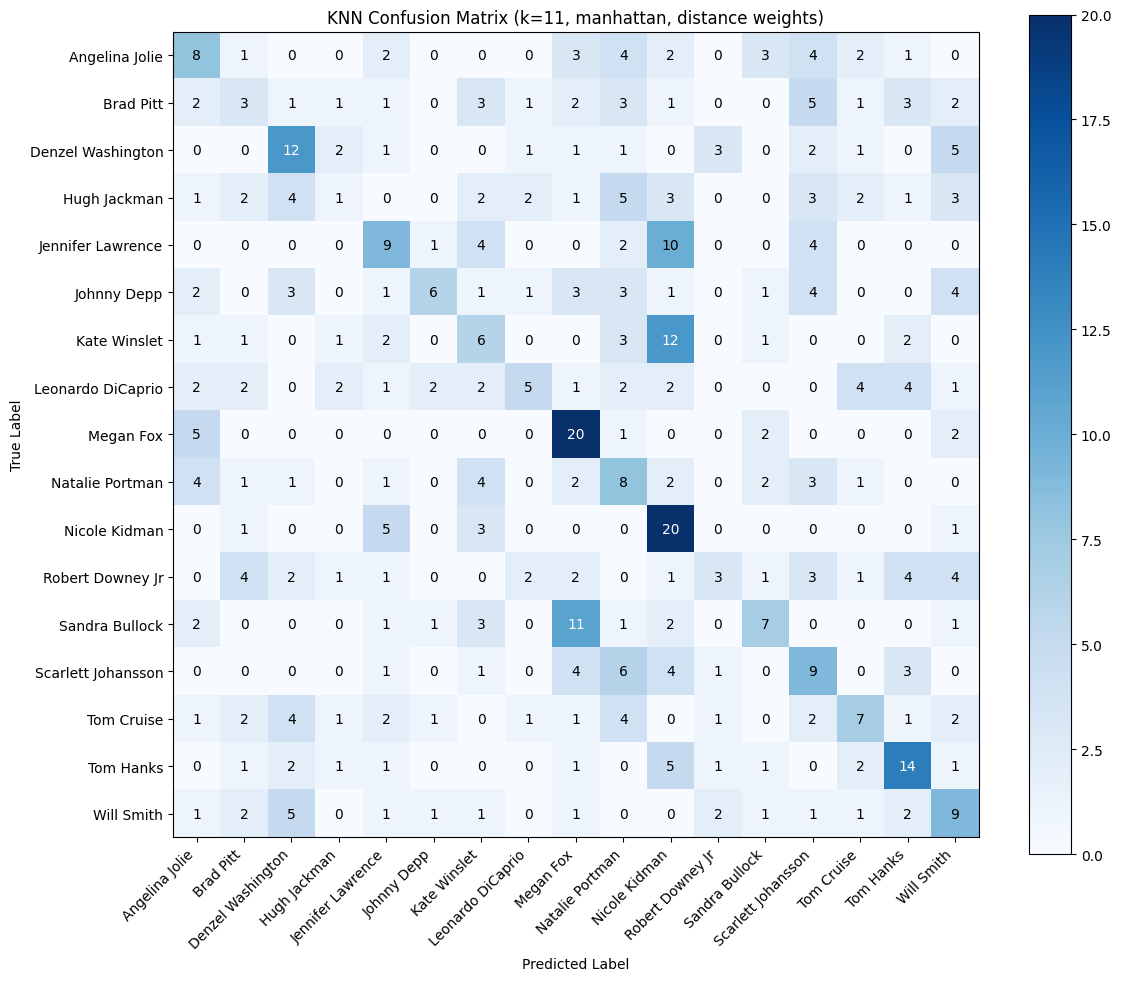


=== Per-Celebrity Accuracy (KNN k=11, manhattan, distance weights) ===


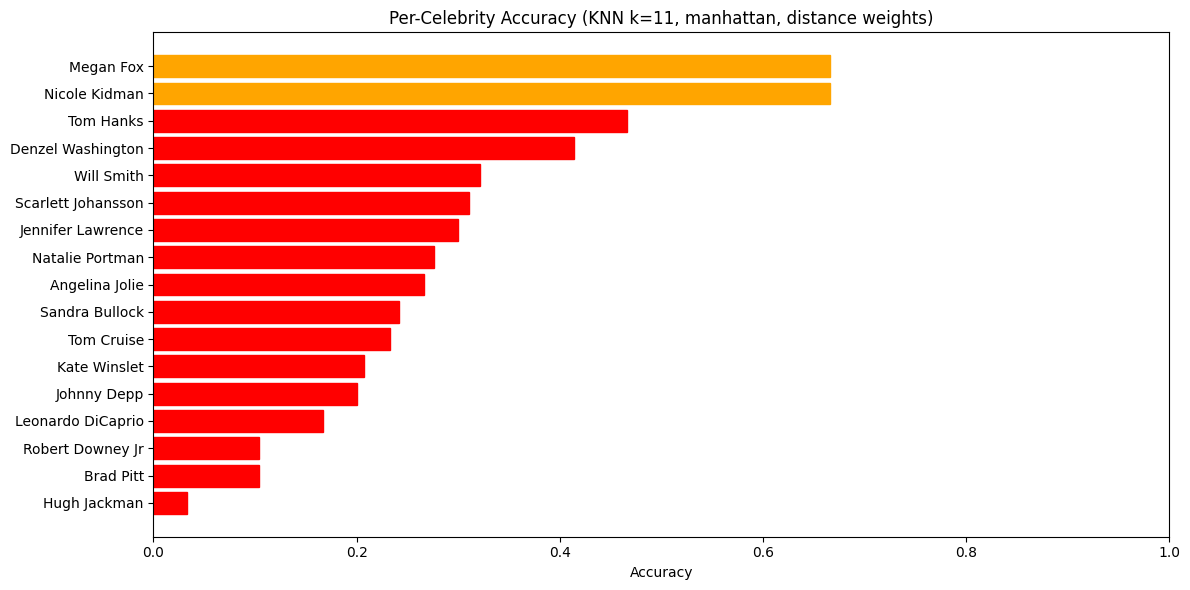

In [18]:

# Flatten the images for KNN (KNN expects 1D features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print(X_train_flat.shape)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(X_test_flat.shape)
print(f"Training KNN with {X_train_flat.shape[1]} features per image")

# Use best parameters from grid search
best_knn = KNeighborsClassifier(
    n_neighbors=11, 
    metric='manhattan', 
    weights='distance'
)

print(f"\nTraining KNN with best parameters: k=11, metric=manhattan, weights=distance")
best_knn.fit(X_train_flat, y_train)

# Predict
y_pred_knn = best_knn.predict(X_test_flat)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN accuracy: {accuracy_knn:.4f}")

# Plot confusion matrix for KNN
plt.figure(figsize=(12, 10))
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.imshow(cm_knn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix (k=11, manhattan, distance weights)')
plt.colorbar()

# Add text annotations
thresh = cm_knn.max() / 2.
for i in range(cm_knn.shape[0]):
    for j in range(cm_knn.shape[1]):
        plt.text(j, i, format(cm_knn[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_knn[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45, ha='right')
plt.yticks(range(len(le.classes_)), le.classes_)
plt.tight_layout()
plt.show()

# Per-celebrity accuracy for KNN
print(f"\n=== Per-Celebrity Accuracy (KNN k=11, manhattan, distance weights) ===")
celeb_accuracies_knn = {}
for i, celeb in enumerate(le.classes_):
    mask = y_test == i
    if np.sum(mask) > 0:
        celeb_accuracy = np.mean(y_pred_knn[mask] == y_test[mask])
        celeb_accuracies_knn[celeb] = celeb_accuracy
        #print(f"{celeb:20s}: {celeb_accuracy:.3f} ({np.sum(mask)} samples)")

# Plot per-celebrity accuracy bar chart for KNN
plt.figure(figsize=(12, 6))
celebrities = list(celeb_accuracies_knn.keys())
accuracies = list(celeb_accuracies_knn.values())

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
celebrities_sorted = [celebrities[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

bars = plt.barh(range(len(celebrities_sorted)), accuracies_sorted)
plt.yticks(range(len(celebrities_sorted)), celebrities_sorted)
plt.xlabel('Accuracy')
plt.title('Per-Celebrity Accuracy (KNN k=11, manhattan, distance weights)')
plt.xlim(0, 1)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    if acc >= 0.7:
        bar.set_color('green')
    elif acc >= 0.5:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()


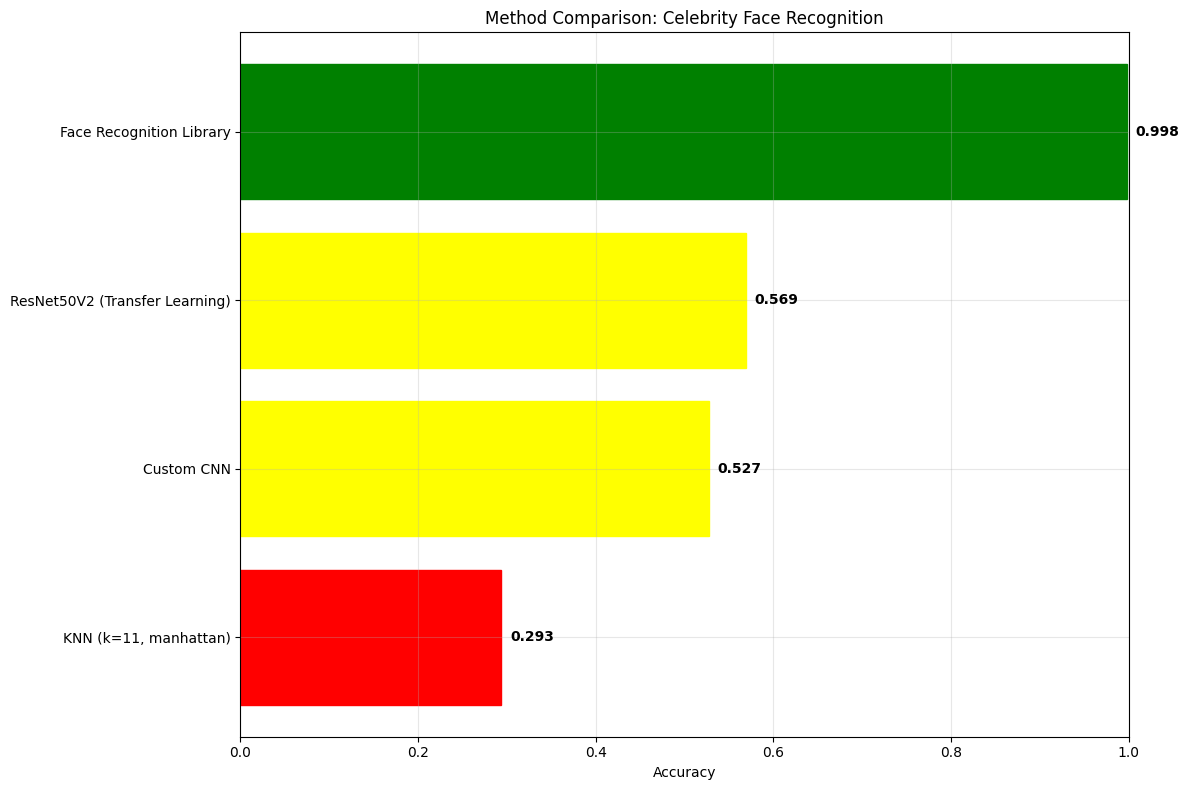

=== METHOD COMPARISON SUMMARY ===
Method                         Accuracy   Rank 
---------------------------------------------
KNN (k=11, manhattan)          0.293      4    
Custom CNN                     0.527      3    
ResNet50V2 (Transfer Learning) 0.569      2    
Face Recognition Library       0.998      1    

Best performing method: Face Recognition Library (0.998)

=== PERFORMANCE ANALYSIS ===
Mean accuracy across all methods: 0.597
Standard deviation: 0.254


In [21]:
# Collect all results
methods_comparison = {
    'KNN (k=11, manhattan)': accuracy_knn,  # From your KNN run
    'ResNet50V2 (Transfer Learning)': test_accuracy_tl,  # From your ResNet run
    'Custom CNN': test_accuracy_cnn,  # From your earlier CNN results (replace with actual value)
    'Face Recognition Library': overall_accuracy  # From your face_recognition results
}

# Create comparison plot
plt.figure(figsize=(12, 8))

# Bar plot
methods = list(methods_comparison.keys())
accuracies = list(methods_comparison.values())

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
methods_sorted = [methods[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

bars = plt.barh(range(len(methods_sorted)), accuracies_sorted)
plt.yticks(range(len(methods_sorted)), methods_sorted)
plt.xlabel('Accuracy')
plt.title('Method Comparison: Celebrity Face Recognition')
plt.xlim(0, 1)

# Color bars based on performance
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    if acc >= 0.8:
        bar.set_color('green')
    elif acc >= 0.6:
        bar.set_color('orange')
    elif acc >= 0.4:
        bar.set_color('yellow')
    else:
        bar.set_color('red')

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies_sorted)):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{acc:.3f}', ha='left', va='center', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed comparison
print("=== METHOD COMPARISON SUMMARY ===")
print(f"{'Method':<30} {'Accuracy':<10} {'Rank':<5}")
print("-" * 45)
for i, (method, acc) in enumerate(zip(methods_sorted, accuracies_sorted)):
    rank = len(methods_sorted) - i
    print(f"{method:<30} {acc:<10.3f} {rank:<5}")

# Find best method
best_method = max(methods_comparison, key=methods_comparison.get)
best_accuracy = methods_comparison[best_method]
print(f"\nBest performing method: {best_method} ({best_accuracy:.3f})")

# Performance analysis
print(f"\n=== PERFORMANCE ANALYSIS ===")
mean_accuracy = np.mean(list(methods_comparison.values()))
std_accuracy = np.std(list(methods_comparison.values()))
print(f"Mean accuracy across all methods: {mean_accuracy:.3f}")
print(f"Standard deviation: {std_accuracy:.3f}")



## Conclusion 

There are two primary finidng with respect to this study.

